In [1]:
#!pip install -q git+https://github.com/tensorflow/docs
#!pip install imutils
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
import warnings

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 2
EPOCHS = 13

MAX_SEQ_LENGTH = 1
NUM_FEATURES = 1000

In [3]:
train_df = pd.read_csv("/SN/train/SNtrain-4.csv")
test_df = pd.read_csv("/SN/test/SNtest.csv")
#val_df = pd.read_csv("/SN/train/SNtrain-5.csv")
train_df= train_df.sample(frac=1, random_state=0)
#val_df= val_df.sample(frac=1, random_state=0)
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")
#print(f"Total videos for training: {len(val_df)}")
train_df.head(10)

Total videos for training: 28
Total videos for testing: 8


,video_name,event
2,Card_1_135_2015-04-11-BE-3-0.mp4,Card
22,Foul_2_1897_2017-01-14-BL-5-0.mp4,Foul
14,Corner_1_182_2015-02-21.mp4,Corner
17,Corner_1_2021_2015-02-21.mp4,Corner
5,Card_1_494_2015-04-05-MP-2-3.mp4,Card
11,Clearence_1_2077_2015-05-23-BD-2-2.mp4,Clearence
24,Foul_2_696_2015-11-22-IF-4-0.mp4,Foul
13,Clearence_2_1594_2015-05-23-BD-2-2.mp4,Clearence
20,Corner_2_449_2015-02-21.mp4,Corner
25,Foul_2_969_2015-11-22-IF-4-0.mp4,Foul


In [4]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [5]:
def build_feature_extractor():
    
    feature_extractor = keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    #for layer in feature_extractor.layers[0:]:
     # layer.trainable = False
    feature_extractor.trainable = False
    preprocess_input = keras.applications.resnet.preprocess_input
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    #outputs = keras.layers.Dense(1024, activation="relu")(outputs)
    outputs = keras.layers.Dense(1000, activation="relu")(outputs)
    outputs = keras.layers.Flatten()(outputs)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [6]:
import warnings

feature_extractor = build_feature_extractor()

In [7]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                 

In [8]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["event"])
)
print(label_processor.get_vocabulary())

['Card', 'Clearence', 'Corner', 'Foul']


In [12]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["event"].values
    labels = label_processor(labels[..., None]).numpy()
    labels = pd.get_dummies(df["event"])
    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "/SN/train")
val_data, val_labels = prepare_all_videos(test_df, "/SN/test")
#X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, random_state=0)
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

1/1 [==============================] - 0s 190ms/step
Frame features in train set: (28, 1, 1000)
Frame masks in train set: (28, 1)


In [14]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()
    #X_train, X_test, y_train, y_test = train_test_split([train_data[0], train_data[1]], train_labels, random_state=0)
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(64, return_sequences=None, dropout=0.5)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.LSTM(64, return_sequences=None)(
        frame_features_input, mask=mask_input
    )
    #x = keras.layers.GRU(64)(x)
    #x = keras.layers.Dropout(0.2)(x)
    #x = keras.layers.Dense(32, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    #rnn_model.compile(
        #loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    #)
    return rnn_model

# Utility for running experiments.
def run_experiment():
    filepath = "train/cp.ckpt"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()

    seq_model.compile(
        loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999), metrics=["accuracy"]
    )
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        #batch_size=BATCH_SIZE,
        #validation_split=0.3,
        #validation_data = ([val_data[0], val_data[1]], val_labels),
        test_sprit=0.3,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint],
        #callbacks=[F1Callback(seq_model,test_data, test_labels)]
    )
    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    metrics = ['loss', 'accuracy']  # 使用する評価関数を指定

    plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

    #for i in range(len(metrics)):

    #    metric = metrics[i]

     #   plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分け、i+1番目のスペースを使う
      #  plt.title(metric)  # グラフのタイトルを表示
    
       # plt_train = history.history[metric]  # historyから訓練データの評価を取り出す
        #plt_test = history.history['val_' + metric]  # historyからテストデータの評価を取り出す
        #plt.plot(plt_train, label='training')  # 訓練データの評価をグラフにプロット
        #plt.plot(plt_test, label='test')  # テストデータの評価をグラフにプロット
        #plt.legend()  # ラベルの表示
    
    #plt.show()  # グラフの表示
    
    return history, seq_model


_, sequence_model = run_experiment()


TypeError: fit() got an unexpected keyword argument 'test_sprit'

In [11]:
sequence_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1, 1000)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 64)           272640      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 4)            260         ['lstm[0][0]']               

In [12]:
pred = sequence_model.predict(train_data)
pred

1/1 [==============================] - 2s 2s/step


array([[0.26865268, 0.43708268, 0.20592918, 0.0883355 ],
       [0.29396877, 0.39172718, 0.19667244, 0.11763162],
       [0.18677352, 0.43620706, 0.26203197, 0.11498746],
       [0.23307224, 0.45248067, 0.19550215, 0.11894494],
       [0.23941705, 0.29394925, 0.35506657, 0.11156712],
       [0.24648762, 0.30540872, 0.23797621, 0.21012744],
       [0.3255356 , 0.33410084, 0.19553392, 0.14482963],
       [0.27344197, 0.3027831 , 0.29920465, 0.12457034],
       [0.23738247, 0.36953133, 0.24365294, 0.14943327],
       [0.29700658, 0.35164005, 0.21837023, 0.13298318],
       [0.2980215 , 0.35113356, 0.24071997, 0.11012498],
       [0.29409403, 0.3656335 , 0.21904479, 0.12122767],
       [0.2548945 , 0.25363785, 0.28636873, 0.20509894],
       [0.24978055, 0.25027204, 0.24956904, 0.25037834],
       [0.30173966, 0.36469975, 0.2010004 , 0.1325601 ],
       [0.27171066, 0.2791225 , 0.2928908 , 0.15627599],
       [0.2998347 , 0.40852734, 0.15664452, 0.13499346],
       [0.28483444, 0.25330672,

In [13]:
pred = np.round(pred)
pred

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [14]:
true = pd.get_dummies(train_df["event"])
true

,Card,Clearence,Corner,Foul
2,1,0,0,0
22,0,0,0,1
14,0,0,1,0
17,0,0,1,0
5,1,0,0,0
11,0,1,0,0
24,0,0,0,1
13,0,1,0,0
20,0,0,1,0
25,0,0,0,1


In [15]:
from sklearn.metrics import confusion_matrix  #混同行列
from sklearn.metrics import accuracy_score, precision_score #適合率
from sklearn.metrics import recall_score, f1_score #再現率,F1スコア

print("accuracy score:",accuracy_score(true,pred))
print("precision score:",precision_score(true, pred, average='micro'))
print("recall score:",recall_score(true, pred, average='micro'))
print("f1 score:",f1_score(true, pred, average='micro'))
#cm = confusion_matrix(true, data)

accuracy score: 0.0
precision score: 0.0
recall score: 0.0
f1 score: 0.0


C:\Users\kimura-lab\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(true, pred)
print(cm)
#sns.heatmap(cm, annot=True, cmap='Blues')
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Card', 'Clearence','Corner','Foul']); ax.yaxis.set_ticklabels(['Card', 'Clearence','Corner','Foul']);

ValueError: multilabel-indicator is not supported

In [17]:
data = sequence_model.predict(train_data)

1/1 [==============================] - 0s 32ms/step


In [18]:
data = np.argmax(data, axis=1)

In [19]:
data

array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 2, 0,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [20]:
labels = train_df["event"].values
labels = label_processor(labels[..., None]).numpy()
labels

array([[0],
       [3],
       [2],
       [2],
       [0],
       [1],
       [3],
       [1],
       [2],
       [3],
       [2],
       [0],
       [1],
       [3],
       [3],
       [1],
       [0],
       [0],
       [2],
       [2],
       [1],
       [1],
       [3],
       [0],
       [0],
       [3],
       [2],
       [1]], dtype=int64)

In [21]:
from sklearn.metrics import confusion_matrix  #混同行列
from sklearn.metrics import accuracy_score, precision_score #適合率
from sklearn.metrics import recall_score, f1_score #再現率,F1スコア

print("accuracy score:",accuracy_score(labels,data))
print("precision score:",precision_score(labels, data, average='micro'))
print("recall score:",recall_score(labels, data, average='micro'))
print("f1 score:",f1_score(labels, data, average='micro'))
#cm = confusion_matrix(true, data)

accuracy score: 0.14285714285714285
precision score: 0.14285714285714285
recall score: 0.14285714285714285
f1 score: 0.14285714285714285


[[0 5 2 0]
 [1 3 3 0]
 [0 7 0 0]
 [0 6 0 1]]


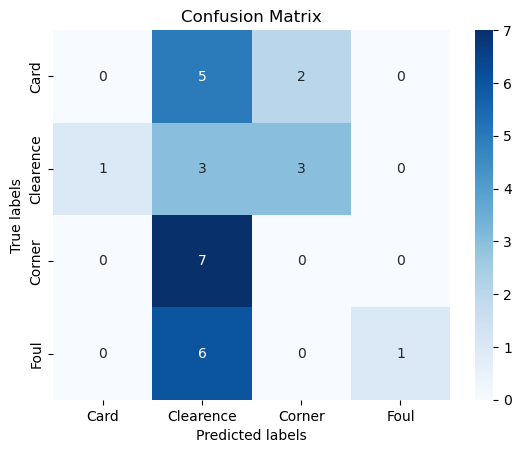

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt     

cm = confusion_matrix(labels, data)
print(cm)
#sns.heatmap(cm, annot=True, cmap='Blues')
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Card', 'Clearence','Corner','Foul']); ax.yaxis.set_ticklabels(['Card', 'Clearence','Corner','Foul']);

In [25]:
train_data

(array([[[0.8568438 , 0.20060405, 0.9204993 , ..., 0.40925935,
          0.        , 0.        ]],
 
        [[1.179917  , 0.2658035 , 0.        , ..., 0.3057506 ,
          0.        , 0.        ]],
 
        [[0.52527887, 0.        , 0.017657  , ..., 0.        ,
          0.        , 1.2340406 ]],
 
        ...,
 
        [[1.6803997 , 0.5594368 , 0.        , ..., 1.2439927 ,
          0.        , 0.5198404 ]],
 
        [[2.210055  , 0.        , 0.        , ..., 0.7634284 ,
          0.        , 0.5797493 ]],
 
        [[0.        , 0.        , 0.10461764, ..., 0.        ,
          0.        , 0.        ]]], dtype=float32),
 array([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
       

In [ ]:
train_data[0]

In [ ]:
from sklearn.metrics import f1_score
score_accurracy = accuracy_score(t_test,y_pred)
print(f"ACC : {score_accurancy*100:.2f}%")

In [16]:
pip install --upgrade sklearn.metrics

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("/SN/test/", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


# test_video = np.random.choice(test_df["video_name"].values.tolist())
test_video ="Clearence_1_562_2015-02-21.mp4"
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
pip install jupyter-resource-usage

In [ ]:
jupyter serverextension enable --py jupyter-resource-usage --sys-prefix